In [133]:
# import 
import torch
import pandas as pd
import numpy as np
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import re
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import torch.optim as optim

from sklearn.model_selection import train_test_split


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [145]:
# random seed
def set_seed(seed_value):
    random.seed(seed_value)  # 파이썬 난수 생성기
    np.random.seed(seed_value)  # Numpy 난수 생성기
    torch.manual_seed(seed_value)  # PyTorch 난수 생성기

    # CUDA 환경에 대한 시드 설정 (GPU 사용 시)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
SEED = 42
set_seed(SEED)

In [134]:
# data 불러오기
train_df = pd.read_csv('../data/train.csv') 
test_df = pd.read_csv('../data/test.csv') 

In [135]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [136]:
train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
1,3,Carlyle Looks Toward Commercial Aerospace (Reuters),"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
3,3,Iraq Halts Oil Exports from Main Southern Pipeline (Reuters),"Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday."
4,3,"Oil prices soar to all-time record, posing new menace to US economy (AFP)","AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections."


## 전처리를 해야할까?

평균 길이: 193.39
최대 길이: 985
최소 길이: 6


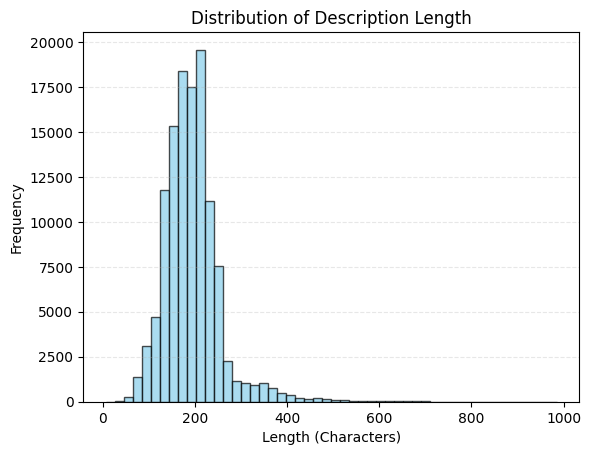

In [137]:
import matplotlib.pyplot as plt

train_df['desc_len'] = train_df['Description'].str.len()


plt.hist(train_df['desc_len'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Distribution of Description Length')
plt.xlabel('Length (Characters)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3, linestyle='--') 

print(f"평균 길이: {train_df['desc_len'].mean():.2f}")
print(f"최대 길이: {train_df['desc_len'].max()}")
print(f"최소 길이: {train_df['desc_len'].min()}")

plt.show()

In [138]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [139]:
# 전처리
# 1. 공백제거
# 2. 대문자 소문자
train_df = train_df.replace(r'^\s*$', np.nan, regex=True)
train_df = train_df.dropna()

# package 에서 복붙해옴 걍
def __basic_english_normalize(line):
    _patterns = [r"\'", r"\"", r"\.", r"<br \/>", r",", r"\(", r"\)", r"\!", r"\?", r"\;", r"\:", r"\s+"]
    _replacements = [" '  ", "", " . ", " ", " , ", " ( ", " ) ", " ! ", " ? ", " ", " ", " "]
    _patterns_dict = list((re.compile(p), r) for p, r in zip(_patterns, _replacements))
    line = line.lower()
    for pattern_re, replaced_str in _patterns_dict:
        line = pattern_re.sub(replaced_str, line)
    return line

train_df['Title'] = train_df['Title'].apply(__basic_english_normalize)
train_df['Description'] = train_df['Description'].apply(__basic_english_normalize)

# 4분의 1만 쓰겠다!
train_df = train_df.sample(frac=0.25, random_state=42)


In [140]:
# vocab
def build_vocab(df, min_freq=1):
    counter = Counter()
    for idx, row in df.iterrows():
        text = str(row['Title']) + " " + str(row['Description'])
        clean_text = __basic_english_normalize(text)
        counter.update(clean_text.split())
    
    # <pad>: 0, <unk>: 1
    vocab = {'<pad>': 0, '<unk>': 1}
    for word, count in counter.items():
        if count >= min_freq:
            vocab[word] = len(vocab)
            
    print(f"Vocab 크기: {len(vocab)}")
    return vocab

In [141]:
train_df['Class Index'].value_counts(normalize = True)

Class Index
2    0.252000
4    0.250933
1    0.249067
3    0.248000
Name: proportion, dtype: float64

In [ ]:
# data Loader

class CustomDataset(Dataset):
    # 이따빼기
    def __basic_english_normalize(slef, line):
        _patterns = [r"\'", r"\"", r"\.", r"<br \/>", r",", r"\(", r"\)", r"\!", r"\?", r"\;", r"\:", r"\s+"]
        _replacements = [" '  ", "", " . ", " ", " , ", " ( ", " ) ", " ! ", " ? ", " ", " ", " "]
        _patterns_dict = list((re.compile(p), r) for p, r in zip(_patterns, _replacements))
        line = line.lower()
        for pattern_re, replaced_str in _patterns_dict:
            line = pattern_re.sub(replaced_str, line)
        return line
    
    
    def __init__(self, df, vocab, is_train=True):
        self.vocab = vocab
        self.is_train = is_train
        
        self.data = []
        self.labels = []
        
        for _, row in df.iterrows():
            # 전처리?
            text = str(row['Title']) + " " + str(row['Description'])
            text = self.__basic_english_normalize(text)
            token_ids = []
            for word in text.split():
                token_ids.append(self.vocab.get(word, 1))
            
            self.data.append(torch.tensor(token_ids, dtype=torch.long))
            # 굳이.. 걍 다들 하길래 함... ㅎㅎ
            self.labels.append(int(row['Class Index']) - 1)
        
    #  데이터 전체 길이  
    def __len__(self):
        return len(self.data)
    
    # 어떻게 반환?
    def __getitem__(self, idx):
        if self.is_train:
            return self.data[idx], self.labels[idx] # train 만 class index 값 넘기기
        else:
            return self.data[idx]
    

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers, 
                            bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        output, (hidden, cell) = self.lstm(embedded)
        
        # 마지막 hidden state 가져오기 (Bidirectional)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

In [ ]:
# 동적 패딩? ???? *** by yhkim
def collate_batch(batch):
    label_list, text_list = [], []
    for (_text, _label) in batch:
        text_list.append(_text)
        label_list.append(_label)
        
    # 텍스트: 패딩 적용 (배치 내 가장 긴 문장 기준)
    inputs_padded = pad_sequence(text_list, batch_first=True, padding_value=0)
    # 라벨: 텐서 변환
    labels_stacked = torch.tensor(label_list, dtype=torch.long)
    
    return inputs_padded, labels_stacked

In [ ]:

train_df = pd.read_csv("../data/train.csv", header=0, names=['Class Index', 'Title', 'Description'])
train_df = train_df.sample(frac=0.25, random_state=42)

test_df = pd.read_csv("../data/test.csv", header=0, names=['Class Index', 'Title', 'Description'])

MIN_FREQ = 2
BATCH_SIZE = 64
vocab = build_vocab(train_df, min_freq=MIN_FREQ)

train_dataset = CustomDataset(train_df, vocab, is_train=True)
test_dataset = CustomDataset(test_df, vocab, is_train=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

INPUT_DIM = len(vocab)
EMBED_DIM = 64
HIDDEN_DIM = 128
OUTPUT_DIM = 4
DROPOUT = 0.5

model = LSTMClassifier(INPUT_DIM, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, n_layers=2, dropout=DROPOUT)

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        # 이전 배치 초기화
        optimizer.zero_grad()
        # 예...측?
        output = model(data)
        # loss function
        loss = criterion(output, label)
        acc = (output.argmax(1) == label).float().mean()
        # 역전파 - 기울기 계산
        loss.backward()
        # 가중치 업데이트 
        optimizer.step()
        # 손실값 누적?
        epoch_loss += loss.item()
        epoch_acc += acc.item()   
         
    return epoch_loss / len(train_loader), epoch_acc / len(train_loader)    

# 검증? inference?
def evaluate(model, test_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    
    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            loss = criterion(output, label)
            acc = (output.argmax(1) == label).float().mean()
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(test_loader), epoch_acc / len(test_loader)


EPOCHS = 5
print(f"학습 시작! (Device: {device})")

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion, device)
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {valid_loss:.3f} | Val Acc: {valid_acc*100:.2f}%')

Vocab 크기: 21868
학습 시작! (Device: cpu)


KeyboardInterrupt: 

## Train

In [ ]:
# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# random seed
def set_seed(seed_value):
    random.seed(seed_value)  # 파이썬 난수 생성기
    np.random.seed(seed_value)  # Numpy 난수 생성기
    torch.manual_seed(seed_value)  # PyTorch 난수 생성기

    # CUDA 환경에 대한 시드 설정 (GPU 사용 시)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        
        # 이전 배치 초기화
        optimizer.zero_grade()
        # 예...측?
        output = model(data)
        # loss function
        loss = criterion(output, target)
        # 역전파 - 기울기 계산
        loss.backward()
        # 가중치 업데이트 
        optimizer.step()
        # 손실값 누적?
        total_loss += loss.item()
    
    return total_loss / len(train_loader)    

In [ ]:
# 검증? inference?
def validate(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    actuals = []
    predictions = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            
            output = model(data)
            loss = criterion(output, target.view(-1, 1)) #????
            total_loss += loss.item()
            
            # 예측값 실제값 저장
            actuals.extend(target.squeeze(1).tolist())
            predictions.extend(output.squeeze(1).tolist())
            
    avg_loss = total_loss / len(test_loader)

    return avg_loss, actuals, predictions